TensorFlow - Yason Dawson

# TFLite_Linear Regression

## Setup

In [1]:
try:
    %tensorflow_version 2.x
except:
    pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

print('\u2022 Using TensorFlow Version:', tf.__version__)

• Using TensorFlow Version: 2.8.2


## Create a Basic Model of the Form y = mx + c

In [3]:
# Create a simple Keras model.
x = [-1, 0, 1, 2, 3, 4]
y = [-3, -1, 1, 3, 5, 7]

model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(units=1, input_shape=[1])
])

model.compile(optimizer='sgd',
              loss='mean_squared_error')

model.fit(x, y, epochs=200)

Epoch 1/200
1/1 [==============================] - 1s 624ms/step - loss: 43.1035
Epoch 2/200
1/1 [==============================] - 0s 14ms/step - loss: 34.2791
Epoch 3/200
1/1 [==============================] - 0s 11ms/step - loss: 27.3289
Epoch 4/200
1/1 [==============================] - 0s 12ms/step - loss: 21.8535
Epoch 5/200
1/1 [==============================] - 0s 11ms/step - loss: 17.5384
Epoch 6/200
1/1 [==============================] - 0s 9ms/step - loss: 14.1364
Epoch 7/200
1/1 [==============================] - 0s 11ms/step - loss: 11.4530
Epoch 8/200
1/1 [==============================] - 0s 13ms/step - loss: 9.3350
Epoch 9/200
1/1 [==============================] - 0s 12ms/step - loss: 7.6620
Epoch 10/200
1/1 [==============================] - 0s 13ms/step - loss: 6.3392
Epoch 11/200
1/1 [==============================] - 0s 10ms/step - loss: 5.2921
Epoch 12/200
1/1 [==============================] - 0s 12ms/step - loss: 4.4621
Epoch 13/200
1/1 [========================

## Generate a SavedModel

In [4]:
export_dir = 'saved_model/1'
tf.saved_model.save(model, export_dir)

## Convert the SavedModel to TFLite

In [5]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [6]:
tflite_model_file = pathlib.Path('model.tflite')
tflite_model_file.write_bytes(tflite_model)

884

## Initialize the TFLite Interpreter To Try It Out

In [7]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [8]:
# Test the TensorFlow Lite model on random input data.
input_shape = input_details[0]['shape']
inputs, outputs = [], []
for _ in range(100):
    input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    
    interpreter.invoke()
    tflite_results = interpreter.get_tensor(output_details[0]['index'])
    
    # Test the TensorFlow model on random input data.
    tf_results = model(tf.constant(input_data))
    output_data = np.array(tf_results)
    
    inputs.append(input_data[0][0])
    outputs.append(output_data[0][0])

## Visualize the Model

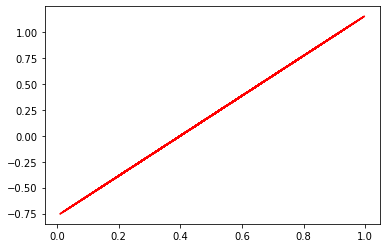

In [9]:
%matplotlib inline

plt.plot(inputs, outputs, 'r')
plt.show()

## Download Fashion MNIST Dataset

In [10]:
try:
    from google.colab import files
    files.download(tflite_model_file)
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()


print('\u2022 Using TensorFlow Version:', tf.__version__)
print('\u2022 GPU Device Found.' if tf.test.is_gpu_available() 
else '\u2022 GPU Device Not Found. Running on CPU')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


• Using TensorFlow Version: 2.8.2
• GPU Device Not Found. Running on CPU


In [12]:
splits = ['train[:80%]+test[:80%]','train[80%:90%]+test[80%:90%]', 'train[90%:]+test[90%:]']

splits, info = tfds.load('fashion_mnist', with_info=True, as_supervised=True, split=splits)

(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

Dataset fashion_mnist downloaded and prepared to ~/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


The class names are not included with the dataset, so we will specify them here.

In [13]:
class_names = ['T-shirt_top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [14]:
# Create a labels.txt file with the class names
with open('labels.txt', 'w') as f:
    f.write('\n'.join(class_names))

In [15]:
# The images in the dataset are 28 by 28 pixels.
IMG_SIZE = 28

## Preprocessing data

In [16]:
def format_example(image, label):
    
    image =tf.cast(x=image, dtype = tf.float32) #YOUR CODE HERE
        
    # Normalize the image in the range [0, 1]
    image = image * 1.0/255.0
    
    return image, label

In [17]:
# Specify the batch size
BATCH_SIZE = 256

In [18]:
# Create Datasets
train_batches = train_examples.cache().shuffle(num_examples//4).batch(BATCH_SIZE).map(format_example).prefetch(1)
validation_batches = validation_examples.cache().batch(BATCH_SIZE).map(format_example)
test_batches = test_examples.batch(1).map(format_example)

## Building The Model

In [19]:
model = tf.keras.Sequential([
    # Set the input shape to (28, 28, 1), kernel size=3, filters=16 and use ReLU activation,
    tf.keras.layers.Conv2D(16,(3,3), activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(),
      
    # Set the number of filters to 32, kernel size to 3 and use ReLU activation 
    tf.keras.layers.Conv2D(32,(3,3), activation = 'relu'),
      
    # Flatten the output layer to 1 dimension
    tf.keras.layers.Flatten(),
      
    # Add a fully connected layer with 64 hidden units and ReLU activation
    tf.keras.layers.Dense(units = 64, activation = 'relu'),
      
    # Attach a final softmax classification head
    tf.keras.layers.Dense(units=10, activation='softmax')])

# Set the appropriate loss function and use accuracy as your metric
model.compile(optimizer='adam',
              loss= 'sparse_categorical_crossentropy' ,#YOUR CODE HERE,
              metrics= ['accuracy'] )#YOUR CODE HERE

In [20]:
model.fit(train_batches, 
          epochs=10,
          validation_data=validation_batches)

Epoch 1/10
219/219 [==============================] - 29s 125ms/step - loss: 0.6047 - accuracy: 0.7871 - val_loss: 0.4110 - val_accuracy: 0.8504
Epoch 2/10
219/219 [==============================] - 24s 112ms/step - loss: 0.3852 - accuracy: 0.8648 - val_loss: 0.3460 - val_accuracy: 0.8753
Epoch 3/10
219/219 [==============================] - 25s 112ms/step - loss: 0.3399 - accuracy: 0.8819 - val_loss: 0.3268 - val_accuracy: 0.8813
Epoch 4/10
219/219 [==============================] - 24s 110ms/step - loss: 0.3072 - accuracy: 0.8914 - val_loss: 0.3079 - val_accuracy: 0.8870
Epoch 5/10
219/219 [==============================] - 24s 111ms/step - loss: 0.2863 - accuracy: 0.8990 - val_loss: 0.2874 - val_accuracy: 0.8976
Epoch 6/10
219/219 [==============================] - 24s 110ms/step - loss: 0.2684 - accuracy: 0.9041 - val_loss: 0.2868 - val_accuracy: 0.8961
Epoch 7/10
219/219 [==============================] - 24s 109ms/step - loss: 0.2509 - accuracy: 0.9111 - val_loss: 0.2808 - val_ac

In [21]:
# EXERCISE: Use the tf.saved_model API to save your model in the SavedModel format. 
export_dir = 'saved_model/1'

tf.saved_model.save(model,export_dir=export_dir)

In [22]:
#@title Select mode of optimization
mode = "Speed" #@param ["Default", "Storage", "Speed"]

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [23]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)# YOUR CODE HERE

# Set the optimzations
converter.optimizations = [optimization]# YOUR CODE HERE

# Invoke the converter to finally generate the TFLite model
tflite_model = converter.convert()# YOUR CODE HERE

In [24]:
tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

259648

## Test the Model with TFLite Interpreter 

In [25]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [26]:
# Gather results for the randomly sampled test images
predictions = []
test_labels = []
test_images = []

for img, label in test_batches.take(50):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    test_labels.append(label[0])
    test_images.append(np.array(img))

In [27]:
#@title Utility functions for plotting
# Utilities for plotting

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label.numpy():
        color = 'green'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks(list(range(10)), class_names, rotation='vertical')
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array[0], color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array[0])

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('green')

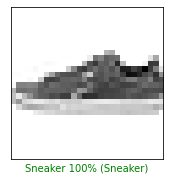

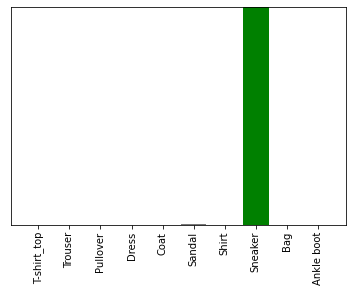

In [28]:
#@title Visualize the outputs { run: "auto" }
index = 13 #@param {type:"slider", min:1, max:50, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_images)
plt.show()
plot_value_array(index, predictions, test_labels)
plt.show()

## Download the TFLite Model and Assets

In [29]:
try:
    from google.colab import files
    
    files.download(tflite_model_file)
    files.download('labels.txt')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
!mkdir -p test_images

In [31]:
from PIL import Image

for index, (image, label) in enumerate(test_batches.take(50)):
    image = tf.cast(image * 255.0, tf.uint8)
    image = tf.squeeze(image).numpy()
    pil_image = Image.fromarray(image)
    pil_image.save('test_images/{}_{}.jpg'.format(class_names[label[0]].lower(), index))

In [32]:
!ls test_images

'ankle boot_10.jpg'   coat_26.jpg       sandal_2.jpg	 trouser_16.jpg
'ankle boot_17.jpg'   coat_31.jpg       sandal_35.jpg	 trouser_20.jpg
'ankle boot_19.jpg'   coat_46.jpg       shirt_24.jpg	 trouser_36.jpg
'ankle boot_4.jpg'    coat_47.jpg       shirt_27.jpg	 trouser_38.jpg
 bag_18.jpg	      coat_48.jpg       shirt_28.jpg	 t-shirt_top_15.jpg
 bag_22.jpg	      dress_12.jpg      shirt_29.jpg	 t-shirt_top_1.jpg
 bag_30.jpg	      dress_45.jpg      shirt_43.jpg	 t-shirt_top_25.jpg
 bag_32.jpg	      dress_6.jpg       shirt_5.jpg	 t-shirt_top_34.jpg
 bag_33.jpg	      pullover_44.jpg   sneaker_13.jpg	 t-shirt_top_37.jpg
 bag_39.jpg	      pullover_9.jpg    sneaker_21.jpg	 t-shirt_top_49.jpg
 bag_3.jpg	      sandal_0.jpg      sneaker_40.jpg	 t-shirt_top_8.jpg
 bag_7.jpg	      sandal_14.jpg     sneaker_41.jpg
 coat_11.jpg	      sandal_23.jpg     sneaker_42.jpg


In [33]:
!zip -qq fmnist_test_images.zip -r test_images/

In [34]:
try:
    files.download('fmnist_test_images.zip')
except:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# TFDS Dataset

In [35]:
!pip install -q tfds-nightly tensorflow matplotlib

     |████████████████████████████████| 4.7 MB 5.0 MB/s 


In [36]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds

## Find available datasets

All dataset builders are subclass of `tfds.core.DatasetBuilder`. To get the list of available builders, use `tfds.list_builders()` or look at our [catalog](https://www.tensorflow.org/datasets/catalog/overview).

In [37]:
tfds.list_builders()

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'answer_equivalence',
 'arc',
 'asqa',
 'asset',
 'assin2',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'bee_dataset',
 'beir',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'ble_wind_field',
 'blimp',
 'booksum',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cardiotox',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'cherry_blossoms',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19',
 'covid19sum',
 'crema_d',
 'criteo',
 'cs_restaurants',
 'cura

## Load a dataset

### tfds.load

The easiest way of loading a dataset is `tfds.load`. It will:

1. Download the data and save it as [`tfrecord`](https://www.tensorflow.org/tutorials/load_data/tfrecord) files.
2. Load the `tfrecord` and create the `tf.data.Dataset`.


In [38]:
ds = tfds.load('mnist', split='train', shuffle_files=True)
assert isinstance(ds, tf.data.Dataset)
print(ds)

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
<PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


In [39]:
builder = tfds.builder('mnist')
# 1. Create the tfrecord files (no-op if already exists)
builder.download_and_prepare()
# 2. Load the `tf.data.Dataset`
ds = builder.as_dataset(split='train', shuffle_files=True)
print(ds)

<PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


## Iterate over a dataset

### As dict

By default, the `tf.data.Dataset` object contains a `dict` of `tf.Tensor`s:

In [40]:
ds = tfds.load('mnist', split='train')
ds = ds.take(1)  # Only take a single example

for example in ds:  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
  print(list(example.keys()))
  image = example["image"]
  label = example["label"]
  print(image.shape, label)

['image', 'label']
(28, 28, 1) tf.Tensor(4, shape=(), dtype=int64)


### As tuple (`as_supervised=True`)

By using `as_supervised=True`, you can get a tuple `(features, label)` instead for supervised datasets.

In [41]:
ds = tfds.load('mnist', split='train', as_supervised=True)
ds = ds.take(1)

for image, label in ds:  # example is (image, label)
  print(image.shape, label)

(28, 28, 1) tf.Tensor(4, shape=(), dtype=int64)


### As numpy (`tfds.as_numpy`)

Uses `tfds.as_numpy` to convert:

*   `tf.Tensor` -> `np.array`
*   `tf.data.Dataset` -> `Iterator[Tree[np.array]]` (`Tree` can be arbitrary nested `Dict`, `Tuple`)



In [42]:
ds = tfds.load('mnist', split='train', as_supervised=True)
ds = ds.take(1)

for image, label in tfds.as_numpy(ds):
  print(type(image), type(label), label)

<class 'numpy.ndarray'> <class 'numpy.int64'> 4


### As batched tf.Tensor (`batch_size=-1`)

By using `batch_size=-1`, you can load the full dataset in a single batch.

This can be combined with `as_supervised=True` and `tfds.as_numpy` to get the the data as `(np.array, np.array)`:


In [43]:
image, label = tfds.as_numpy(tfds.load(
    'mnist',
    split='test',
    batch_size=-1,
    as_supervised=True,
))

print(type(image), image.shape)

<class 'numpy.ndarray'> (10000, 28, 28, 1)


## Benchmark your datasets

Benchmarking a dataset is a simple `tfds.benchmark` call on any iterable (e.g. `tf.data.Dataset`, `tfds.as_numpy`,...).


In [44]:
ds = tfds.load('mnist', split='train')
ds = ds.batch(32).prefetch(1)

tfds.benchmark(ds, batch_size=32)
tfds.benchmark(ds, batch_size=32)  # Second epoch much faster due to auto-caching


************ Summary ************

Examples/sec (First included) 12006.86 ex/sec (total: 60000 ex, 5.00 sec)
Examples/sec (First only) 898.69 ex/sec (total: 32 ex, 0.04 sec)
Examples/sec (First excluded) 12086.58 ex/sec (total: 59968 ex, 4.96 sec)

************ Summary ************

Examples/sec (First included) 89053.80 ex/sec (total: 60000 ex, 0.67 sec)
Examples/sec (First only) 1204.54 ex/sec (total: 32 ex, 0.03 sec)
Examples/sec (First excluded) 92659.90 ex/sec (total: 59968 ex, 0.65 sec)


,duration,num_examples,avg
first+lasts,0.673750,60000,89053.795541
first,0.026566,32,1204.542722
lasts,0.647184,59968,92659.898288


## Visualization

### tfds.as_dataframe

`tf.data.Dataset` objects can be converted to [`pandas.DataFrame`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) with `tfds.as_dataframe` to be visualized on [Colab](https://colab.research.google.com).

* Add the `tfds.core.DatasetInfo` as second argument of `tfds.as_dataframe` to visualize images, audio, texts, videos,...
* Use `ds.take(x)` to only display the first `x` examples. `pandas.DataFrame` will load the full dataset in-memory, and can be very expensive to display.

In [45]:
ds, info = tfds.load('mnist', split='train', with_info=True)

tfds.as_dataframe(ds.take(4), info)

,image,label
0,,4
1,,1
2,,0
3,,7


### tfds.show_examples

`tfds.show_examples` returns a `matplotlib.figure.Figure` (only image datasets supported now):

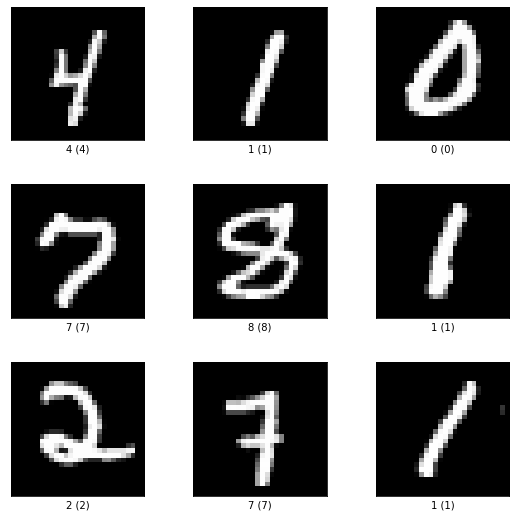

In [46]:
ds, info = tfds.load('mnist', split='train', with_info=True)

fig = tfds.show_examples(ds, info)

## Access the dataset metadata

All builders include a `tfds.core.DatasetInfo` object containing the dataset metadata.

It can be accessed through:

*   The `tfds.load` API:


In [47]:
ds, info = tfds.load('mnist', with_info=True)

In [48]:
builder = tfds.builder('mnist')
info = builder.info

In [49]:
print(info)

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='~/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)


In [50]:
info.features

FeaturesDict({
    'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})

In [51]:
print(info.features["label"].num_classes)
print(info.features["label"].names)
print(info.features["label"].int2str(7))  # Human readable version (8 -> 'cat')
print(info.features["label"].str2int('7'))

10
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
7
7


In [52]:
print(info.features.shape)
print(info.features.dtype)
print(info.features['image'].shape)
print(info.features['image'].dtype)

{'image': (28, 28, 1), 'label': ()}
{'image': tf.uint8, 'label': tf.int64}
(28, 28, 1)
<dtype: 'uint8'>


In [53]:
print(info.splits)

{'test': <SplitInfo num_examples=10000, num_shards=1>, 'train': <SplitInfo num_examples=60000, num_shards=1>}


In [54]:
print(list(info.splits.keys()))

['test', 'train']


In [55]:
print(info.splits['train'].num_examples)
print(info.splits['train'].filenames)
print(info.splits['train'].num_shards)

60000
['mnist-train.tfrecord-00000-of-00001']
1


In [56]:
print(info.splits['train[15%:75%]'].num_examples)
print(info.splits['train[15%:75%]'].file_instructions)

36000
[FileInstruction(filename='~/tensorflow_datasets/mnist/3.0.1/mnist-train.tfrecord-00000-of-00001', skip=9000, take=36000, num_examples=36000)]


#TDFS Rock_Paper_Scissor

## Setup

In [57]:
try:
    %tensorflow_version 2.x
except:
    pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [58]:
# Use all imports
import tensorflow as tf
import tensorflow_datasets as tfds

print("\u2022 Using TensorFlow Version:", tf.__version__)

• Using TensorFlow Version: 2.8.2


## Extract the Rock, Paper, Scissors Dataset

In the cell below, you will extract the `rock_paper_scissors` dataset and then print its info. Take note of the splits, what they're called, and their size.

In [59]:
data, info = tfds.load("rock_paper_scissors", with_info=True)
print(info)

Dataset rock_paper_scissors downloaded and prepared to ~/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_path='~/tensorflow_datasets/rock_paper_scissors/3.0.0',
    file_format=tfrecord,
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "

In [60]:
for set in data:# YOUR CODE HERE
  print(set,":", info.splits[set].num_examples)

train : 2520
test : 372


The original dataset doesn't have a validation set, just training and testing sets. In the cell below, you will use TFDS to create new datasets according to these rules:

* `new_train`: The new training set should be the first 90% of the original training set.


* `new_test`: The new test set should be the first 90% of the original test set.


* `validation`: The new validation set should be the last 10% of the original training set + the last 10% of the original test set.

In [61]:
#(Include the following arguments in your code: "rock_paper_scissors:3.*.*")
new_train = tfds.load("rock_paper_scissors:3.*.*", split='train[:90%]')
print(len(list(new_train)))

#(Include the following arguments in your code: "rock_paper_scissors:3.*.*")

new_test = tfds.load("rock_paper_scissors:3.*.*", split='test[:90%]')
print(len(list(new_test)))

#(Include the following arguments in your code: "rock_paper_scissors:3.*.*")
validation = tfds.load("rock_paper_scissors:3.*.*", split='train[90%:] + test[90%:]')
print(len(list(validation)))

2268
335
289


# TFDS Parallelization

## Setup

In [62]:
try:
    %tensorflow_version 2.x
except:
    pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [63]:
import os
import textwrap
import scipy.io
import pandas as pd

import tensorflow as tf

print("\u2022 Using TensorFlow Version:", tf.__version__)

• Using TensorFlow Version: 2.8.2


## IMDB Faces Dataset

This is the largest publicly available dataset of face images with gender and age labels for training.

Source: https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/

The IMDb Faces dataset provides a separate .mat file which can be loaded with Matlab containing all the meta information. The format is as follows:  
**dob**: date of birth (Matlab serial date number)  
**photo_taken**: year when the photo was taken  
**full_path**: path to file  
**gender**: 0 for female and 1 for male, NaN if unknown  
**name**: name of the celebrity  
**face_location**: location of the face (bounding box)  
**face_score**: detector score (the higher the better). Inf implies that no face was found in the image and the face_location then just returns the entire image  
**second_face_score**: detector score of the face with the second highest score. This is useful to ignore images with more than one face. second_face_score is NaN if no second face was detected.  
**celeb_names**: list of all celebrity names  
**celeb_id**: index of celebrity name

Here you can download the raw images and the metadata. We also provide a version with the cropped faces (with 40% margin). This version is much smaller.

In [64]:
# Download and extract the IMDB Faces dataset
!wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar
!tar xf imdb_crop.tar

--2022-09-14 14:20:29--  https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7012157440 (6.5G) [application/x-tar]
Saving to: ‘imdb_crop.tar’

imdb_crop.tar       100%[===================>]   6.53G  23.7MB/s    in 4m 47s  

2022-09-14 14:25:17 (23.3 MB/s) - ‘imdb_crop.tar’ saved [7012157440/7012157440]



## Exploring the Data

In [65]:
# Inspect the directory structure
files = os.listdir('imdb_crop')
print(textwrap.fill(' '.join(sorted(files)), 80))

00 01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80
81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 imdb.mat


In [66]:
# Inspect the meta data
meta = scipy.io.loadmat('/content/imdb_crop/imdb.mat')
meta

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Jan 17 11:30:27 2016',
 '__version__': '1.0',
 '__globals__': [],
 'imdb': array([[(array([[693726, 693726, 693726, ..., 726831, 726831, 726831]], dtype=int32), array([[1968, 1970, 1968, ..., 2011, 2011, 2011]], dtype=uint16), array([[array(['01/nm0000001_rm124825600_1899-5-10_1968.jpg'], dtype='<U43'),
                 array(['01/nm0000001_rm3343756032_1899-5-10_1970.jpg'], dtype='<U44'),
                 array(['01/nm0000001_rm577153792_1899-5-10_1968.jpg'], dtype='<U43'),
                 ...,
                 array(['08/nm3994408_rm926592512_1989-12-29_2011.jpg'], dtype='<U44'),
                 array(['08/nm3994408_rm943369728_1989-12-29_2011.jpg'], dtype='<U44'),
                 array(['08/nm3994408_rm976924160_1989-12-29_2011.jpg'], dtype='<U44')]],
               dtype=object), array([[1., 1., 1., ..., 0., 0., 0.]]), array([[array(['Fred Astaire'], dtype='<U12'),
                 array(['Fred Astaire'], d

## Extraction

In [67]:
root = meta['imdb'][0, 0]

In [68]:
desc = root.dtype.descr
desc

[('dob', '|O'),
 ('photo_taken', '|O'),
 ('full_path', '|O'),
 ('gender', '|O'),
 ('name', '|O'),
 ('face_location', '|O'),
 ('face_score', '|O'),
 ('second_face_score', '|O'),
 ('celeb_names', '|O'),
 ('celeb_id', '|O')]

In [69]:
# EXERCISE: Fill in the missing code below.

full_path = root["full_path"][0]

# Do the same for other attributes
names = root['name'][0] # YOUR CODE HERE
dob = root['dob'][0]# YOUR CODE HERE
gender = root['gender'][0]# YOUR CODE HERE
photo_taken = root['photo_taken'][0]# YOUR CODE HERE
face_score = root['face_score'][0]# YOUR CODE HERE
face_locations = root['face_location'][0]# YOUR CODE HERE
second_face_score = root['second_face_score'][0]# YOUR CODE HERE
celeb_names = root['celeb_names'][0]# YOUR CODE HERE
celeb_ids = root['celeb_id'][0]# YOUR CODE HERE

print('Filepaths: {}\n\n'
      'Names: {}\n\n'
      'Dates of birth: {}\n\n'
      'Genders: {}\n\n'
      'Years when the photos were taken: {}\n\n'
      'Face scores: {}\n\n'
      'Face locations: {}\n\n'
      'Second face scores: {}\n\n'
      'Celeb IDs: {}\n\n'
      .format(full_path, names, dob, gender, photo_taken, face_score, face_locations, second_face_score, celeb_ids))

Filepaths: [array(['01/nm0000001_rm124825600_1899-5-10_1968.jpg'], dtype='<U43')
 array(['01/nm0000001_rm3343756032_1899-5-10_1970.jpg'], dtype='<U44')
 array(['01/nm0000001_rm577153792_1899-5-10_1968.jpg'], dtype='<U43') ...
 array(['08/nm3994408_rm926592512_1989-12-29_2011.jpg'], dtype='<U44')
 array(['08/nm3994408_rm943369728_1989-12-29_2011.jpg'], dtype='<U44')
 array(['08/nm3994408_rm976924160_1989-12-29_2011.jpg'], dtype='<U44')]

Names: [array(['Fred Astaire'], dtype='<U12')
 array(['Fred Astaire'], dtype='<U12')
 array(['Fred Astaire'], dtype='<U12') ...
 array(['Jane Levy'], dtype='<U9') array(['Jane Levy'], dtype='<U9')
 array(['Jane Levy'], dtype='<U9')]

Dates of birth: [693726 693726 693726 ... 726831 726831 726831]

Genders: [1. 1. 1. ... 0. 0. 0.]

Years when the photos were taken: [1968 1970 1968 ... 2011 2011 2011]

Face scores: [1.45969291 2.5431976  3.45557949 ...       -inf 4.45072452 2.13350269]

Face locations: [array([[1072.926,  161.838, 1214.784,  303.696]])
 a

In [70]:
print('Celeb names: {}\n\n'.format(celeb_names))

Celeb names: [array(["'Lee' George Quinones"], dtype='<U21')
 array(["'Weird Al' Yankovic"], dtype='<U19')
 array(['2 Chainz'], dtype='<U8') ...
 array(['Éric Caravaca'], dtype='<U13')
 array(['Ólafur Darri Ólafsson'], dtype='<U21')
 array(['Óscar Jaenada'], dtype='<U13')]




Display all the distinct keys and their corresponding values

In [71]:
names = [x[0] for x in desc]
names

['dob',
 'photo_taken',
 'full_path',
 'gender',
 'name',
 'face_location',
 'face_score',
 'second_face_score',
 'celeb_names',
 'celeb_id']

In [72]:
values = {key: root[key][0] for key in names}
values

{'dob': array([693726, 693726, 693726, ..., 726831, 726831, 726831], dtype=int32),
 'photo_taken': array([1968, 1970, 1968, ..., 2011, 2011, 2011], dtype=uint16),
 'full_path': array([array(['01/nm0000001_rm124825600_1899-5-10_1968.jpg'], dtype='<U43'),
        array(['01/nm0000001_rm3343756032_1899-5-10_1970.jpg'], dtype='<U44'),
        array(['01/nm0000001_rm577153792_1899-5-10_1968.jpg'], dtype='<U43'),
        ...,
        array(['08/nm3994408_rm926592512_1989-12-29_2011.jpg'], dtype='<U44'),
        array(['08/nm3994408_rm943369728_1989-12-29_2011.jpg'], dtype='<U44'),
        array(['08/nm3994408_rm976924160_1989-12-29_2011.jpg'], dtype='<U44')],
       dtype=object),
 'gender': array([1., 1., 1., ..., 0., 0., 0.]),
 'name': array([array(['Fred Astaire'], dtype='<U12'),
        array(['Fred Astaire'], dtype='<U12'),
        array(['Fred Astaire'], dtype='<U12'), ...,
        array(['Jane Levy'], dtype='<U9'),
        array(['Jane Levy'], dtype='<U9'),
        array(['Jane Levy']

## Cleanup

In [73]:
del values['celeb_names']
names.pop(names.index('celeb_names'))

'celeb_names'

In [74]:
for key, value in values.items():
    print(key, len(value))

dob 460723
photo_taken 460723
full_path 460723
gender 460723
name 460723
face_location 460723
face_score 460723
second_face_score 460723
celeb_id 460723


## Dataframe

In [75]:
df = pd.DataFrame(values, columns=names)
df.head()

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,celeb_id
0,693726,1968,[01/nm0000001_rm124825600_1899-5-10_1968.jpg],1.0,[Fred Astaire],"[[1072.926, 161.838, 1214.7839999999999, 303.6...",1.459693,1.118973,6488
1,693726,1970,[01/nm0000001_rm3343756032_1899-5-10_1970.jpg],1.0,[Fred Astaire],"[[477.184, 100.352, 622.592, 245.76]]",2.543198,1.852008,6488
2,693726,1968,[01/nm0000001_rm577153792_1899-5-10_1968.jpg],1.0,[Fred Astaire],"[[114.96964308962852, 114.96964308962852, 451....",3.455579,2.985660,6488
3,693726,1968,[01/nm0000001_rm946909184_1899-5-10_1968.jpg],1.0,[Fred Astaire],"[[622.8855056426588, 424.21750383700805, 844.3...",1.872117,NaN,6488
4,693726,1968,[01/nm0000001_rm980463616_1899-5-10_1968.jpg],1.0,[Fred Astaire],"[[1013.8590023603723, 233.8820422075853, 1201....",1.158766,NaN,6488


In [76]:
df.isna().sum()

dob                       0
photo_taken               0
full_path                 0
gender                 8462
name                      0
face_location             0
face_score                0
second_face_score    246926
celeb_id                  0
dtype: int64

## TensorFlow Datasets

TFDS provides a way to transform all those datasets into a standard format, do the preprocessing necessary to make them ready for a machine learning pipeline, and provides a standard input pipeline using `tf.data`.

To enable this, each dataset implements a subclass of `DatasetBuilder`, which specifies:

* Where the data is coming from (i.e. its URL). 
* What the dataset looks like (i.e. its features).  
* How the data should be split (e.g. TRAIN and TEST). 
* The individual records in the dataset.

The first time a dataset is used, the dataset is downloaded, prepared, and written to disk in a standard format. Subsequent access will read from those pre-processed files directly.

## Clone the TFDS Repository

The next step will be to clone the GitHub TFDS Repository. For this particular notebook, we will clone a particular version of the repository. You can clone the repository by running the following command:

In [77]:
!git clone https://github.com/tensorflow/datasets.git -b v1.2.0

Cloning into 'datasets'...
remote: Enumerating objects: 82919, done.
remote: Counting objects: 100% (1303/1303), done.
remote: Compressing objects: 100% (477/477), done.
remote: Total 82919 (delta 651), reused 1202 (delta 600), pack-reused 81616
Receiving objects: 100% (82919/82919), 956.46 MiB | 32.68 MiB/s, done.
Resolving deltas: 100% (56698/56698), done.
Note: checking out 'dc4b79f5c4dbdb0db1c5b614f8d790bdc0013de1'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

Checking out files: 100% (4185/4185), done.


In [78]:
cd /content/datasets

/content/datasets


In [79]:
%%writefile something.py
x = 10

Writing something.py


In [80]:
!cat something.py

x = 10


## Define the Dataset with `GeneratorBasedBuilder`

Most datasets subclass `tfds.core.GeneratorBasedBuilder`, which is a subclass of `tfds.core.DatasetBuilder` that simplifies defining a dataset. It works well for datasets that can be generated on a single machine. Its subclasses implement:

* `_info`: builds the DatasetInfo object describing the dataset


* `_split_generators`: downloads the source data and defines the dataset splits


* `_generate_examples`: yields (key, example) tuples in the dataset from the source data

In this exercise, you will use the `GeneratorBasedBuilder`.

### EXERCISE: Fill in the missing code below.

In [81]:
"""IMDB Faces dataset."""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import os
import re

import tensorflow as tf
import tensorflow_datasets.public_api as tfds

_DESCRIPTION = """\
Since the publicly available face image datasets are often of small to medium size, rarely exceeding tens of thousands of images, and often without age information we decided to collect a large dataset of celebrities. For this purpose, we took the list of the most popular 100,000 actors as listed on the IMDb website and (automatically) crawled from their profiles date of birth, name, gender and all images related to that person. Additionally we crawled all profile images from pages of people from Wikipedia with the same meta information. We removed the images without timestamp (the date when the photo was taken). Assuming that the images with single faces are likely to show the actor and that the timestamp and date of birth are correct, we were able to assign to each such image the biological (real) age. Of course, we can not vouch for the accuracy of the assigned age information. Besides wrong timestamps, many images are stills from movies - movies that can have extended production times. In total we obtained 460,723 face images from 20,284 celebrities from IMDb and 62,328 from Wikipedia, thus 523,051 in total.

As some of the images (especially from IMDb) contain several people we only use the photos where the second strongest face detection is below a threshold. For the network to be equally discriminative for all ages, we equalize the age distribution for training. For more details please the see the paper. 
"""

_URL = ("https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/")
_DATASET_ROOT_DIR = 'imdb_crop' # Put the name of the dataset root directory here
_ANNOTATION_FILE = 'imdb.mat' # Put the name of annotation file here (.mat file)


_CITATION = """\
@article{Rothe-IJCV-2016,
  author = {Rasmus Rothe and Radu Timofte and Luc Van Gool},
  title = {Deep expectation of real and apparent age from a single image without facial landmarks},
  journal = {International Journal of Computer Vision},
  volume={126},
  number={2-4},
  pages={144--157},
  year={2018},
  publisher={Springer}
}
@InProceedings{Rothe-ICCVW-2015,
  author = {Rasmus Rothe and Radu Timofte and Luc Van Gool},
  title = {DEX: Deep EXpectation of apparent age from a single image},
  booktitle = {IEEE International Conference on Computer Vision Workshops (ICCVW)},
  year = {2015},
  month = {December},
}
"""

# Source URL of the IMDB faces dataset
_TARBALL_URL = "https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar"

class ImdbFaces(tfds.core.GeneratorBasedBuilder):
  """IMDB Faces dataset."""

  VERSION = tfds.core.Version("0.1.0")
  
  def _info(self):
    return tfds.core.DatasetInfo(
        builder=self,
        description=_DESCRIPTION,
        # Describe the features of the dataset by following this url
        # https://www.tensorflow.org/datasets/api_docs/python/tfds/features
        features=tfds.features.FeaturesDict({
            "image":tfds.features.Image(), # Create a tfds Image feature here
            "gender":tfds.features.ClassLabel(num_classes=2),  # Create a tfds Class Label feature here for the two classes (Female, Male)
            "dob":tf.int32, # YOUR CODE HERE
            "photo_taken":tf.int32, # YOUR CODE HERE
            "face_location":tfds.features.BBoxFeature(), # Create a tfds Bounding box feature here
            "face_score":tf.float32, # YOUR CODE HERE
            "second_face_score":tf.float32, # YOUR CODE HERE
            "celeb_id":tf.int32 # YOUR CODE HERE
        }),
        supervised_keys=("image", "gender"),
        urls=[_URL],
        citation=_CITATION)

  def _split_generators(self, dl_manager):
    # Download the dataset and then extract it.
    download_path = dl_manager.download([_TARBALL_URL])
    extracted_path = dl_manager.download_and_extract([_TARBALL_URL])

    # Parsing the mat file which contains the list of train images
    def parse_mat_file(file_name):
      with tf.io.gfile.GFile(file_name, "rb") as f:
        # Add a lazy import for scipy.io and import the loadmat method to 
        # load the annotation file
        dataset = tfds.core.lazy_imports.scipy.io.loadmat(file_name)# YOUR CODE HERE
      return dataset

    # Parsing the mat file by using scipy's loadmat method
    # Pass the path to the annotation file using the downloaded/extracted paths above
    meta = parse_mat_file(os.path.join(extracted_path[0], _DATASET_ROOT_DIR, _ANNOTATION_FILE))# YOUR CODE HERE)

    # Get the names of celebrities from the metadata
    # celeb_names = meta[0,0]["celeb_names"][0]  # YOUR CODE HERE
    celeb_names = meta['imdb']["celeb_names"][0]# YOUR CODE HERE

    # Create tuples out of the distinct set of genders and celeb names
    self.info.features['gender'].names = tuple("Female","Male") # YOUR CODE HERE
    self.info.features['celeb_id'].names = tuple([x[0] for x in celeb_names]) # YOUR CODE HERE

    return [
        tfds.core.SplitGenerator(
            name=tfds.Split.TRAIN,
            gen_kwargs={
                "image_dir": extracted_path[0],
                "metadata": meta,
            })
    ]

  def _get_bounding_box_values(self, bbox_annotations, img_width, img_height):
    """Function to get normalized bounding box values.

    Args:
      bbox_annotations: list of bbox values in kitti format
      img_width: image width
      img_height: image height

    Returns:
      Normalized bounding box xmin, ymin, xmax, ymax values
    """

    ymin = bbox_annotations[0] / img_height
    xmin = bbox_annotations[1] / img_width
    ymax = bbox_annotations[2] / img_height
    xmax = bbox_annotations[3] / img_width
    return ymin, xmin, ymax, xmax
  
  def _get_image_shape(self, image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    shape = image.shape[:2]
    return shape

  def _generate_examples(self, image_dir, metadata):
    # Add a lazy import for pandas here (pd)
    pd = tfds.core.lazy_imports.pandas# YOUR CODE HERE

    # Extract the root dictionary from the metadata so that you can query all the keys inside it
    root = metadata[0, 0]

    """Extract image names, dobs, genders,  
               face locations, 
               year when the photos were taken,
               face scores (second face score too),
               celeb ids
    """
    image_names = root["full_path"][0]
        
    # Do the same for other attributes (dob, genders etc)
    dobs = root["dob"][0]# YOUR CODE HERE
    genders = root["gender"][0]# YOUR CODE HERE
    face_locations = root["face_location"][0]# YOUR CODE HERE
    photo_taken_years = root["photo_taken"][0] # YOUR CODE HERE
    face_scores = root["face_score"][0] # YOUR CODE HERE
    second_face_scores = root["second_face_score"][0] # YOUR CODE HERE
    celeb_id = root["celeb_id"][0] # YOUR CODE HERE
        
    # Now create a dataframe out of all the features like you've seen before
    df = pd.DataFrame(
        list(zip(image_names,
                 dobs,
                 genders,
                 face_locations,
                 photo_taken_years,
                 face_scores,
                 second_face_scores,
                 celeb_id)
            ),
        columns=['image_names', 
                 'dobs', 
                 'genders', 
                 'face_locations',
                 'photo_taken_years',
                 'face_scores',
                 'second_face_scores',
                 'celeb_ids'
                ]
    )# YOUR CODE HERE

    # Filter dataframe by only having the rows with face_scores > 1.0
    df = df[df['face_scores'] > 1.0] # YOUR CODE HERE


    # Remove any records that contain Nulls/NaNs by checking for NaN with .isna()
    df = df[~df['genders'].isna()]
    df = df[~df['second_face_scores'].isna()]# YOUR CODE HERE

    # Cast genders to integers so that mapping can take place
    df.genders = df.genders.astype(int)# YOUR CODE HERE

    # Iterate over all the rows in the dataframe and map each feature
    for _, row in df.iterrows():
      # Extract filename, gender, dob, photo_taken, 
      # face_score, second_face_score and celeb_id
      filename = os.path.join(image_dir, _DATASET_ROOT_DIR, row['image_names'][0])
      gender = row['genders']
      dob = row['dobs']
      photo_taken = row['photo_taken_years']
      face_score = row['face_scores']
      second_face_score = row['second_face_scores']
      celeb_id = row['celeb_ids']

      # Get the image shape
      image_width, image_height = self._get_image_shape(filename)
      # Normalize the bounding boxes by using the face coordinates and the image shape
      bbox = self._get_bounding_box_values(row['face_locations'][0], 
                                           image_width, image_height)

      # Yield a feature dictionary 
      yield filename, {
          "image": filename,
          "gender": gender,
          "dob": dob,
          "photo_taken": photo_taken,
          "face_location": tfds.features.BBox(# Create a bounding box (BBox) object out of the coordinates extracted
              ymin=min(bbox[0],1.0),
              xmin=min(bbox[1],1.0),
              ymax=max(bbox[2],1.0),
              xmax=max(bbox[3],1.0)), # Create a bounding box (BBox) object out of the coordinates extracted
          "face_score": face_score,
          "second_face_score": second_face_score,
          "celeb_id": celeb_id
      }

## Add an Import for Registration

All subclasses of `tfds.core.DatasetBuilder` are automatically registered when their module is imported such that they can be accessed through `tfds.builder` and `tfds.load`.

If you're contributing the dataset to `tensorflow/datasets`, you must add the module import to its subdirectory's `__init__.py` (e.g. `image/__init__.py`), as shown below:

In [82]:
%%writefile tensorflow_datasets/image/__init__.py
"""Image datasets."""

from tensorflow_datasets.image.abstract_reasoning import AbstractReasoning
from tensorflow_datasets.image.aflw2k3d import Aflw2k3d
from tensorflow_datasets.image.bigearthnet import Bigearthnet
from tensorflow_datasets.image.binarized_mnist import BinarizedMNIST
from tensorflow_datasets.image.binary_alpha_digits import BinaryAlphaDigits
from tensorflow_datasets.image.caltech import Caltech101
from tensorflow_datasets.image.caltech_birds import CaltechBirds2010
from tensorflow_datasets.image.cats_vs_dogs import CatsVsDogs
from tensorflow_datasets.image.cbis_ddsm import CuratedBreastImagingDDSM
from tensorflow_datasets.image.celeba import CelebA
from tensorflow_datasets.image.celebahq import CelebAHq
from tensorflow_datasets.image.chexpert import Chexpert
from tensorflow_datasets.image.cifar import Cifar10
from tensorflow_datasets.image.cifar import Cifar100
from tensorflow_datasets.image.cifar10_corrupted import Cifar10Corrupted
from tensorflow_datasets.image.clevr import CLEVR
from tensorflow_datasets.image.coco import Coco
from tensorflow_datasets.image.coco2014_legacy import Coco2014
from tensorflow_datasets.image.coil100 import Coil100
from tensorflow_datasets.image.colorectal_histology import ColorectalHistology
from tensorflow_datasets.image.colorectal_histology import ColorectalHistologyLarge
from tensorflow_datasets.image.cycle_gan import CycleGAN
from tensorflow_datasets.image.deep_weeds import DeepWeeds
from tensorflow_datasets.image.diabetic_retinopathy_detection import DiabeticRetinopathyDetection
from tensorflow_datasets.image.downsampled_imagenet import DownsampledImagenet
from tensorflow_datasets.image.dsprites import Dsprites
from tensorflow_datasets.image.dtd import Dtd
from tensorflow_datasets.image.eurosat import Eurosat
from tensorflow_datasets.image.flowers import TFFlowers
from tensorflow_datasets.image.food101 import Food101
from tensorflow_datasets.image.horses_or_humans import HorsesOrHumans
from tensorflow_datasets.image.image_folder import ImageLabelFolder
from tensorflow_datasets.image.imagenet import Imagenet2012
from tensorflow_datasets.image.imagenet2012_corrupted import Imagenet2012Corrupted
from tensorflow_datasets.image.kitti import Kitti
from tensorflow_datasets.image.lfw import LFW
from tensorflow_datasets.image.lsun import Lsun
from tensorflow_datasets.image.mnist import EMNIST
from tensorflow_datasets.image.mnist import FashionMNIST
from tensorflow_datasets.image.mnist import KMNIST
from tensorflow_datasets.image.mnist import MNIST
from tensorflow_datasets.image.mnist_corrupted import MNISTCorrupted
from tensorflow_datasets.image.omniglot import Omniglot
from tensorflow_datasets.image.open_images import OpenImagesV4
from tensorflow_datasets.image.oxford_flowers102 import OxfordFlowers102
from tensorflow_datasets.image.oxford_iiit_pet import OxfordIIITPet
from tensorflow_datasets.image.patch_camelyon import PatchCamelyon
from tensorflow_datasets.image.pet_finder import PetFinder
from tensorflow_datasets.image.quickdraw import QuickdrawBitmap
from tensorflow_datasets.image.resisc45 import Resisc45
from tensorflow_datasets.image.rock_paper_scissors import RockPaperScissors
from tensorflow_datasets.image.scene_parse_150 import SceneParse150
from tensorflow_datasets.image.shapes3d import Shapes3d
from tensorflow_datasets.image.smallnorb import Smallnorb
from tensorflow_datasets.image.so2sat import So2sat
from tensorflow_datasets.image.stanford_dogs import StanfordDogs
from tensorflow_datasets.image.stanford_online_products import StanfordOnlineProducts
from tensorflow_datasets.image.sun import Sun397
from tensorflow_datasets.image.svhn import SvhnCropped
from tensorflow_datasets.image.uc_merced import UcMerced
from tensorflow_datasets.image.visual_domain_decathlon import VisualDomainDecathlon
from tensorflow_datasets.image.voc import Voc2007

# EXERCISE: Import your dataset module here

# YOUR CODE HERE
from tensorflow_datasets.image.imdb_faces import ImdbFaces

Overwriting tensorflow_datasets/image/__init__.py


## URL Checksums

If you're contributing the dataset to `tensorflow/datasets`, add a checksums file for the dataset. On first download, the DownloadManager will automatically add the sizes and checksums for all downloaded URLs to that file. This ensures that on subsequent data generation, the downloaded files are as expected.

In [83]:
!touch tensorflow_datasets/url_checksums/imdb_faces.txt


## Build the Dataset

In [84]:
DATASET_NAME =  "imdb_faces" # YOUR CODE HERE

# Advanced TensorFlow

# Getting Started with TensorFlow Hub

[TensorFlow Hub](https://tfhub.dev/) is a repository of reusable TensorFlow machine learning modules. A module is a self-contained piece of a TensorFlow graph, along with its weights and assets, that can be reused across different tasks. These modules can be reused to solve new tasks with less training data, diminishing training time. 

In this notebook we will go over some basic examples to help you get started with TensorFlow Hub. In particular, we will cover the following topics:

* Loading TensorFlow Hub Modules and Performing Inference.

* Using TensorFlow Hub Modules with Keras.

* Using Feature Vectors with Keras for Transfer Learning.

* Saving and Running a TensorFlow Hub Module Locally.

* Changing the Download Location of TensorFlow Hub Modules. 

In [85]:
try:
    %tensorflow_version 2.x
except:
    pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [86]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

from PIL import Image


print("\u2022 Using TensorFlow Version:", tf.__version__)

• Using TensorFlow Version: 2.8.2


## Download Test Image

We will download the image of a puppy to test our TensorFlow Hub modules.

In [87]:
!wget -O dog.jpeg https://cdn.pixabay.com/photo/2016/12/13/05/15/puppy-1903313_960_720.jpg
    
original_image = Image.open('./dog.jpeg')

--2022-09-14 14:33:06--  https://cdn.pixabay.com/photo/2016/12/13/05/15/puppy-1903313_960_720.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 172.64.150.12, 104.18.37.244, 2606:4700:4400::ac40:960c, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|172.64.150.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109345 (107K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>] 106.78K  --.-KB/s    in 0.02s   

2022-09-14 14:33:06 (5.25 MB/s) - ‘dog.jpeg’ saved [109345/109345]



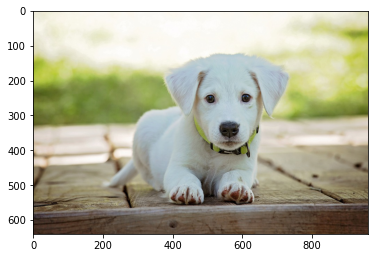

In [88]:
plt.figure(figsize=(6,6))
plt.imshow(original_image)
plt.show()

## Format Image

We will now resize and normalize our image so that is compatible with the module we are going to use. In this notebook we will use the [MobileNet](https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4) model which was trained in ImageNet. For this module, the input images are expected to have color values in the range `[0,1]` and to have an input size of `(224,224)`.

In [89]:
IMAGE_SIZE = (224, 224)
    
img = original_image.resize(IMAGE_SIZE)
img = np.array(img) / 255.0

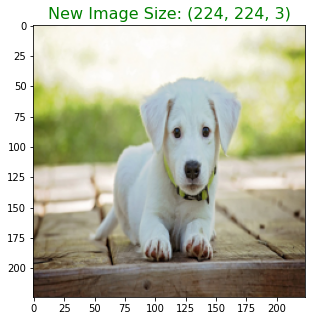

In [90]:
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.title('New Image Size: {}'.format(img.shape), fontdict={'size': 16}, color='green')
plt.show()

## Get ImageNet Labels

We will now get the labels for all the 1001 classes in the ImageNet dataset.

In [91]:
!wget -O labels.txt --quiet https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt

with open('labels.txt', 'r') as f:
    labels = [l.strip() for l in f.readlines()]

# get number of labels
num_classes = len(labels)

print('There are a total of {0} labels representing {0} classes.\n'.format(num_classes))

There are a total of 1001 labels representing 1001 classes.



In [92]:
for label in labels[0:5]:
    print(label)

background
tench
goldfish
great white shark
tiger shark


## Loading a TensorFlow Hub Module

To load a module, we use its unique **module handle**, which is just a URL string. To obtain the module handle, we have to browse through the catalog of modules in the [TensorFlow Hub](https://tfhub.dev/) website. 

For example, in this case, we will be using the complete **MobileNet** model. If we go to [MobileNet's webpage](https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4) in the TensorFlow Hub website, we will see that the module handle for this module is:

```
'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4'
```

Finally, we'll make use of TensorFlow Hub's, `load` API to load the module into memory. 

In [93]:
MODULE_HANDLE = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4'
module = hub.load(MODULE_HANDLE)

## Performing Inference

Once we have loaded the module, we can then start running inference on it. Note however, that the module generates the final layer's logits without any activations. Therefore, we have to apply the `softmax` activation to the module's output. The result will be a Tensor of shape `(1, 1001)`, where the first dimension refers to the batch size. In this case it is just `1` because we only passed 1 image. 

In the cell below, we will pass the image of the puppy and get the top 5 predictions from our model along with their probability scores.

In [94]:
predictions = tf.nn.softmax(module([img]))[0]

top_k_pred_values, top_k_indices = tf.math.top_k(predictions, k=5)

top_k_pred_values = top_k_pred_values.numpy()
top_k_indices = top_k_indices.numpy()

for value, i in zip(top_k_pred_values, top_k_indices):
    print('{}: {:.3}'.format(labels[i], value))

Labrador retriever: 0.406
Great Pyrenees: 0.0701
kuvasz: 0.0577
tennis ball: 0.0473
Old English sheepdog: 0.0298


## Using a TensorFlow Hub Module with Keras

We can also integrate TensorFlow Hub modules into the high level Keras API. In this case, we make use of the `hub.KerasLayer` API to load it. We can add the `hub.KerasLayer` to a Keras `sequential` model along with an activation layer. Once the model is built, all the Keras model methods can be accessed like you would normally do in Keras.

In [95]:
model = tf.keras.Sequential([
        hub.KerasLayer(MODULE_HANDLE,
                       input_shape=IMAGE_SIZE + (3,)),
        tf.keras.layers.Activation('softmax')
])

## Performing Inference

To perform inference with the Keras model, we have to add a dimension to our image to account for the batch size. Remember that our Keras model expects the input to have shape `(batch_size, image_size)`, where the `image_size` includes the number of color channels.

In [96]:
# Add batch dimension
img_arr = np.expand_dims(img, axis=0)

As we did previously, in the cell below we will pass the image of the puppy and get the top 5 predictions from our Keras model along with their probability scores.

In [97]:
predictions = model.predict(img_arr)[0]
 
top_k_pred_values, top_k_indices = tf.math.top_k(predictions, k=5)

top_k_pred_values = top_k_pred_values.numpy()
top_k_indices = top_k_indices.numpy()

for value, i in zip(top_k_pred_values, top_k_indices):
    print('{}: {:.3}'.format(labels[i], value))

Labrador retriever: 0.406
Great Pyrenees: 0.0701
kuvasz: 0.0577
tennis ball: 0.0473
Old English sheepdog: 0.0298


## Using Feature Vectors with Keras

While we can use complete models as we did in the previous section, perhaps, the most important part of TensorFlow Hub is in how it provides **Feature Vectors** that allows us to take advantage of transfer learning. Feature vectors are just complete modules that had their final classification head removed.

In the cell below we show an example of how a feature vector can be added to a Keras `sequential` model.

In [98]:
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [99]:
# Number of classes in the new dataset
NUM_CLASSES = 20

model = tf.keras.Sequential([
        hub.KerasLayer(MODULE_HANDLE,
                       input_shape=IMAGE_SIZE + (3,)),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

Now that the model is built, the next step in transfer learning will be to train the model on a new dataset with the new classifier (i.e. the last layer of the model). Remember that the number of output units in the last layer will correspond to the number of classes in your new dataset. After the model has been trained, we can perform inference in the same way as with any Keras model (see previous section).

## Saving a TensorFlow Hub Module for Local Use

We can download TensorFlow Hub modules, by explicitly downloading the module as a **SavedModel** archived as a tarball. This is useful if we want to work with the module offline.

To do this, we first have to download the Hub module by appending a query parameter to the module handled URL string. This is done by setting the TF Hub format query parameter as shown below. For now, only the compressed option is defined.

In [100]:
MODULE_HANDLE = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4?tf-hub-format=compressed'
!wget -O ./saved_model.tar.gz $MODULE_HANDLE

--2022-09-14 14:35:04--  https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4?tf-hub-format=compressed
Resolving tfhub.dev (tfhub.dev)... 173.194.193.102, 173.194.193.139, 173.194.193.138, ...
Connecting to tfhub.dev (tfhub.dev)|173.194.193.102|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://storage.googleapis.com/tfhub-modules/google/tf2-preview/mobilenet_v2/classification/4.tar.gz [following]
--2022-09-14 14:35:04--  https://storage.googleapis.com/tfhub-modules/google/tf2-preview/mobilenet_v2/classification/4.tar.gz
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.200.128, 209.85.234.128, 142.250.152.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13256595 (13M) [application/x-tar]
Saving to: ‘./saved_model.tar.gz’

./saved_model.tar.g 100%[===================>]  12.64M  --.-KB/s    in 0.1s    

2022-09

In [101]:
# Untar the tarball
!mkdir -p ./saved_model
!tar xvzf ./saved_model.tar.gz -C ./saved_model

./
./assets/
./saved_model.pb
./variables/
./variables/variables.index
./variables/variables.data-00000-of-00001


## Running a TensorFlow Hub Module Locally

We can load the SavedModel containing the saved TensorFlow Hub module by using `hub.load`.

In [102]:
module = hub.load('./saved_model')

After the TensorFlow Hub module is loaded, we can start making inferences as shown below. As before, we will pass the image of the puppy and get the top 5 predictions from our model along with their probability scores.

In [103]:
predictions = tf.nn.softmax(module([img]))[0]

top_k_pred_values, top_k_indices = tf.math.top_k(predictions, k=5)

top_k_pred_values = top_k_pred_values.numpy()
top_k_indices = top_k_indices.numpy()

for value, i in zip(top_k_pred_values, top_k_indices):
    print('{}: {:.3}'.format(labels[i], value))

Labrador retriever: 0.406
Great Pyrenees: 0.0701
kuvasz: 0.0577
tennis ball: 0.0473
Old English sheepdog: 0.0298


## Changing the Download Location of TensorFlow Hub Modules. 

Finally, we can change the download location of TensorFlow Hub modules to a more permanent location. We can do this by setting the environment variable `'TFHUB_CACHE_DIR'` to the directory we want our modules to be saved in. 

In Python, we can set this environment variable in the environment dictionary that's present in the Pythons `os` module as you can see below. 

In [104]:
new_dir = './hub_cache_dir'

os.environ['TFHUB_CACHE_DIR'] = new_dir

In [105]:
MODULE_HANDLE = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4'
module = hub.load(MODULE_HANDLE)

We can take a look the contents of the new directory and all its subdirectories by using the `-R` option.

In [106]:
!ls -R {new_dir}

./hub_cache_dir:
426589ad685896ab7954855255a52db3442cb38d
426589ad685896ab7954855255a52db3442cb38d.descriptor.txt

./hub_cache_dir/426589ad685896ab7954855255a52db3442cb38d:
assets	saved_model.pb	variables

./hub_cache_dir/426589ad685896ab7954855255a52db3442cb38d/assets:

./hub_cache_dir/426589ad685896ab7954855255a52db3442cb38d/variables:
variables.data-00000-of-00001  variables.index


# Getting Started with TensorFlow Serving

In this notebook you will serve your first TensorFlow model with TensorFlow Serving. We will start by building a very simple model to infer the relationship:

$$
y = 2x - 1 
$$

between a few pairs of numbers. After training our model, we will serve it with TensorFlow Serving, and then we will make inference requests.


In [2]:
try:
    %tensorflow_version 2.x
except:
    pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
import os
import json
import tempfile
import requests
import numpy as np

import tensorflow as tf

print("\u2022 Using TensorFlow Version:", tf.__version__)

• Using TensorFlow Version: 2.8.2


## Add TensorFlow Serving Distribution URI as a Package Source

We will install TensorFlow Serving using [Aptitude](https://wiki.debian.org/Aptitude) (the default Debian package manager) since Google's Colab runs in a Debian environment. 

Before we can install TensorFlow Serving, we need to add the `tensorflow-model-server` package to the list of packages that Aptitude knows about. Note that we're running as root.

**Note**: This notebook is running TensorFlow Serving natively, but [you can also run it in a Docker container](https://www.tensorflow.org/tfx/serving/docker), which is one of the easiest ways to get started using TensorFlow Serving. The Docker Engine is available for a variety of Linux platforms, Windows, and Mac.

In [4]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | apt-key add -
!apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  49050      0 --:--:-- --:--:-- --:--:-- 49050
OK
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,026 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:8 

## Install TensorFlow Serving

Now that the Aptitude packages have been updated, we can use the `apt-get` command to install the TensorFlow model server.

In [5]:
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  tensorflow-model-server
0 upgraded, 1 newly installed, 0 to remove and 56 not upgraded.
Need to get 400 MB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 tensorflow-model-server all 2.10.0 [400 MB]
Fetched 400 MB in 14s (27.7 MB/s)
Selecting previously unselected package tensorflow-model-server.
(Reading database ... 155685 files and directories currently installed.)
Preparing to unpack .../tensorflow-model-server_2.10.0_all.deb ...
Unpacking tensorflow-model-server (2.10.0) ...
Setting up tensorflow-model-server (2.10.0) ...


## Create Dataset

Now, we will create a simple dataset that expresses the relationship:

$$
y = 2x - 1 
$$

between inputs (`xs`) and outputs (`ys`).

In [6]:
xs = np.array([-1.0,  0.0, 1.0, 2.0, 3.0, 4.0], dtype=float)
ys = np.array([-3.0, -1.0, 1.0, 3.0, 5.0, 7.0], dtype=float)

## Build and Train the Model

We'll use the simplest possible model for this example. Since we are going to train our model for `500` epochs, in order to avoid clutter on the screen, we will use the argument `verbose=0` in the `fit` method. The Verbosity mode can be:

* `0` : silent.

* `1` : progress bar.

* `2` : one line per epoch.

As a side note, we should mention that since the progress bar is not particularly useful when logged to a file, `verbose=2` is recommended when not running interactively (eg, in a production environment).

In [7]:
model = tf.keras.Sequential([tf.keras.layers.Dense(units=1, input_shape=[1])])
model.compile(optimizer='sgd',
              loss='mean_squared_error')
history = model.fit(xs, ys, epochs=500, verbose=0)
print("Finished training the model")

Finished training the model


## Test the Model

Now that the model is trained, we can test it. If we give it the value `10`, we should get a value very close to `19`.

In [8]:
print(model.predict([10.0]))

[[18.981047]]


## Save the Model

To load the trained model into TensorFlow Serving we first need to save it in the [SavedModel](https://www.tensorflow.org/guide/saved_model) format.  This will create a protobuf file in a well-defined directory hierarchy, and will include a version number.  [TensorFlow Serving](https://www.tensorflow.org/tfx/serving/serving_config) allows us to select which version of a model, or "servable" we want to use when we make inference requests.  Each version will be exported to a different sub-directory under the given path.

In [9]:
MODEL_DIR = tempfile.gettempdir()

version = 1

export_path = os.path.join(MODEL_DIR, str(version))
if os.path.isdir(export_path):
    print('\nAlready saved a model, cleaning up\n')
    !rm -r {export_path}
model.save(export_path, save_format="tf")
print('\nexport_path = {}'.format(export_path))
!ls -l {export_path}


export_path = /tmp/1
total 52
drwxr-xr-x 2 root root  4096 Sep 14 14:38 assets
-rw-r--r-- 1 root root  4092 Sep 14 14:38 keras_metadata.pb
-rw-r--r-- 1 root root 37746 Sep 14 14:38 saved_model.pb
drwxr-xr-x 2 root root  4096 Sep 14 14:38 variables


## Examine Your Saved Model

We'll use the command line utility `saved_model_cli` to look at the `MetaGraphDefs` and `SignatureDefs` in our SavedModel. The signature definition is defined by the input and output tensors, and stored with the default serving key.

In [10]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['dense_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1)
        name: serving_default_dense_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict

Concrete Functions:
  Function Name: '__call__'
    Option #1
      Callable with:
        Argument #1
          inputs: TensorSpec(s

## Run the TensorFlow Model Server

We will now launch the TensorFlow model server with a bash script. We will use the argument `--bg` to run the script in the background.

Our script will start running TensorFlow Serving and will load our model. Here are the parameters we will use:

* `rest_api_port`: The port that you'll use for requests.


* `model_name`: You'll use this in the URL of your requests.  It can be anything.


* `model_base_path`: This is the path to the directory where you've saved your model.

Also, because the variable that points to the directory containing the model is in Python, we need a way to tell the bash script where to find the model. To do this, we will write the value of the Python variable to an environment variable using the `os.environ` function.

In [11]:
os.environ["MODEL_DIR"] = MODEL_DIR

In [12]:
%%bash --bg 
nohup tensorflow_model_server \
--rest_api_port=8501 \
--model_name=helloworld \
--model_base_path="${MODEL_DIR}" >server.log 2>&1

Now we can take a look at the server log.

In [13]:
!tail server.log

tensorflow_model_server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.28' not found (required by tensorflow_model_server)
tensorflow_model_server: /usr/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.26' not found (required by tensorflow_model_server)
tensorflow_model_server: /lib/x86_64-linux-gnu/libm.so.6: version `GLIBC_2.29' not found (required by tensorflow_model_server)


## Create JSON Object with Test Data

We are now ready to construct a JSON object with some data so that we can make a couple of inferences. We will use $x=9$ and $x=10$ as our test data.

In [14]:
xs = np.array([[9.0], [10.0]])
data = json.dumps({"signature_name": "serving_default", "instances": xs.tolist()})
print(data)

{"signature_name": "serving_default", "instances": [[9.0], [10.0]]}


## Make Inference Request

Finally, we can make the inference request and get the inferences back. We'll send a predict request as a POST to our server's REST endpoint, and pass it our test data. We'll ask our server to give us the latest version of our model by not specifying a particular version. The response will be a JSON payload containing the predictions.

In [28]:
import sys

# Confirm that we're using Python 3
assert sys.version_info.major == 3, 'Oops, not running Python 3. Use Runtime > Change runtime type'

In [29]:
# TensorFlow and tf.keras
print("Installing dependencies for Colab environment")
!pip install -Uq grpcio==1.26.0

import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import subprocess

print('TensorFlow version: {}'.format(tf.__version__))

Installing dependencies for Colab environment
     |████████████████████████████████| 2.4 MB 5.2 MB/s 
TensorFlow version: 2.8.2


In [30]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# scale the values to 0.0 to 1.0
train_images = train_images / 255.0
test_images = test_images / 255.0

# reshape for feeding into the model
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print('\ntrain_images.shape: {}, of {}'.format(train_images.shape, train_images.dtype))
print('test_images.shape: {}, of {}'.format(test_images.shape, test_images.dtype))

4431872/4422102 [==============================] - 0s 0us/step

train_images.shape: (60000, 28, 28, 1), of float64
test_images.shape: (10000, 28, 28, 1), of float64


In [31]:
model = keras.Sequential([
  keras.layers.Conv2D(input_shape=(28,28,1), filters=8, kernel_size=3, 
                      strides=2, activation='relu', name='Conv1'),
  keras.layers.Flatten(),
  keras.layers.Dense(10, name='Dense')
])
model.summary()

testing = False
epochs = 5

model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(train_images, train_labels, epochs=epochs)

test_loss, test_acc = model.evaluate(test_images, test_labels)
print('\nTest accuracy: {}'.format(test_acc))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 13, 13, 8)         80        
                                                                 
 flatten (Flatten)           (None, 1352)              0         
                                                                 
 Dense (Dense)               (None, 10)                13530     
                                                                 
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
1875/1875 [==============================] - 16s 8ms/step - loss: 0.5294 - sparse_categorical_accuracy: 0.8179
Epoch 2/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.3799 - sparse_categorical_accuracy: 0.8670
Epoch 3/5
1875/1875 [==============================] - 14s 7ms/step - lo

In [32]:
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/1




Saved model:
total 92
drwxr-xr-x 2 root root  4096 Sep 14 14:38 assets
-rw-r--r-- 1 root root  8234 Sep 14 14:45 keras_metadata.pb
-rw-r--r-- 1 root root 72393 Sep 14 14:45 saved_model.pb
drwxr-xr-x 2 root root  4096 Sep 14 14:45 variables


In [33]:
import sys
# We need sudo prefix if not on a Google Colab.
if 'google.colab' not in sys.modules:
  SUDO_IF_NEEDED = 'sudo'
else:
  SUDO_IF_NEEDED = ''

In [34]:
!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | {SUDO_IF_NEEDED} tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | {SUDO_IF_NEEDED} apt-key add -
!{SUDO_IF_NEEDED} apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0   119k      0 --:--:-- --:--:-- --:--:--  124k
OK
Hit:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hi

In [35]:
! apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tensorflow-model-server is already the newest version (2.10.0).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 56 not upgraded.


In [36]:
os.environ["MODEL_DIR"] = MODEL_DIR

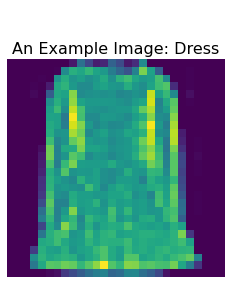

In [37]:
def show(idx, title):
  plt.figure()
  plt.imshow(test_images[idx].reshape(28,28))
  plt.axis('off')
  plt.title('\n\n{}'.format(title), fontdict={'size': 16})

import random
rando = random.randint(0,len(test_images)-1)
show(rando, 'An Example Image: {}'.format(class_names[test_labels[rando]]))

In [38]:
import json
data = json.dumps({"signature_name": "serving_default", "instances": test_images[0:3].tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))

Data: {"signature_name": "serving_default", "instances": ...  [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]]]]}


In [ ]:
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/helloworld:predict', data=data, headers=headers)

print(json_response.text)

In [ ]:
predictions = json.loads(json_response.text)['predictions']
print(predictions)

# Text Classification

In this notebook we will classify movie reviews as being either `positive` or `negative`. We'll use the [IMDB dataset](https://www.tensorflow.org/datasets/catalog/imdb_reviews) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews.

In [41]:
try:
    %tensorflow_version 2.x
except:
    pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [42]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

print("\u2022 Using TensorFlow Version:", tf.__version__)

• Using TensorFlow Version: 2.8.2


## Download the IMDB Dataset

We will download the [IMDB dataset](https://www.tensorflow.org/datasets/catalog/imdb_reviews) using TensorFlow Datasets. We will use a training set, a validation set, and a test set. Since the IMDB dataset doesn't have a validation split, we will use the first 60\% of the training set for training, and the last 40\% of the training set for validation.

In [43]:
splits = ['train[:60%]', 'train[-40%:]', 'test']
splits, info = tfds.load(name="imdb_reviews", with_info=True, split=splits, as_supervised=True)
train_data, validation_data, test_data = splits

Dataset imdb_reviews downloaded and prepared to ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


## Explore the Data 

Let's take a moment to look at the data.

In [44]:
num_train_examples = info.splits['train'].num_examples
num_test_examples = info.splits['test'].num_examples
num_classes = info.features['label'].num_classes

print('The Dataset has a total of:')
print('\u2022 {:,} classes'.format(num_classes))

print('\u2022 {:,} movie reviews for training'.format(num_train_examples))
print('\u2022 {:,} movie reviews for testing'.format(num_test_examples))

The Dataset has a total of:
• 2 classes
• 25,000 movie reviews for training
• 25,000 movie reviews for testing


The labels are either 0 or 1, where 0 is a negative review, and 1 is a positive review. We will create a list with the corresponding class names, so that we can map labels to class names later on.

In [45]:
class_names = ['negative', 'positive']

In [46]:
class_names = ['negative', 'positive']

Each example consists of a sentence representing the movie review and a corresponding label. The sentence is not preprocessed in any way. Let's take a look at the first example of the training set.  

In [47]:
for review, label in train_data.take(1):
    review = review.numpy()
    label = label.numpy()

    print('\nMovie Review:\n\n', review)
    print('\nLabel:', class_names[label])


Movie Review:

 b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."

Label: negative


## Load Word Embeddings

In this example, the input data consists of sentences. The labels to predict are either 0 or 1.

One way to represent the text is to convert sentences into word embeddings. Word embeddings, are an efficient way to represent words using dense vectors, where semantically similar words have similar vectors. We can use a pre-trained text embedding as the first layer of our model, which will have two advantages:

*   We don't have to worry anout text preprocessing.
*   We can benefit from transfer learning.

For this example we will use a model from [TensorFlow Hub](https://tfhub.dev/) called [google/tf2-preview/gnews-swivel-20dim/1](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1). We'll create a `hub.KerasLayer` that uses the TensorFlow Hub model to embed the sentences. We can choose to fine-tune the TF hub module weights during training by setting the `trainable` parameter to `True`.

In [48]:
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"

hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True)

## Build Pipeline

In [49]:
batch_size = 512

train_batches = train_data.shuffle(num_train_examples // 4).batch(batch_size).prefetch(1)
validation_batches = validation_data.batch(batch_size).prefetch(1)
test_batches = test_data.batch(batch_size)

## Build the Model

In the code below we will build a Keras `Sequential` model with the following layers:

1. The first layer is a TensorFlow Hub layer. This layer uses a pre-trained SavedModel to map a sentence into its embedding vector. The model that we are using ([google/tf2-preview/gnews-swivel-20dim/1](https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1)) splits the sentence into tokens, embeds each token and then combines the embedding. The resulting dimensions are: `(num_examples, embedding_dimension)`.


2. This fixed-length output vector is piped through a fully-connected (`Dense`) layer with 16 hidden units.


3. The last layer is densely connected with a single output node. Using the `sigmoid` activation function, this value is a float between 0 and 1, representing a probability, or confidence level.

In [50]:
model = tf.keras.Sequential([
        hub_layer,
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')])

## Train the Model

Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), we'll use the `binary_crossentropy` loss function. 

In [51]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_batches,
                    epochs=20,
                    validation_data=validation_batches)

Epoch 1/20
30/30 [==============================] - 7s 146ms/step - loss: 0.7861 - accuracy: 0.5090 - val_loss: 0.6949 - val_accuracy: 0.5610
Epoch 2/20
30/30 [==============================] - 4s 115ms/step - loss: 0.6673 - accuracy: 0.6033 - val_loss: 0.6487 - val_accuracy: 0.6264
Epoch 3/20
30/30 [==============================] - 2s 74ms/step - loss: 0.6285 - accuracy: 0.6499 - val_loss: 0.6170 - val_accuracy: 0.6621
Epoch 4/20
30/30 [==============================] - 2s 76ms/step - loss: 0.5942 - accuracy: 0.6835 - val_loss: 0.5851 - val_accuracy: 0.6896
Epoch 5/20
30/30 [==============================] - 2s 73ms/step - loss: 0.5563 - accuracy: 0.7188 - val_loss: 0.5518 - val_accuracy: 0.7208
Epoch 6/20
30/30 [==============================] - 2s 75ms/step - loss: 0.5168 - accuracy: 0.7541 - val_loss: 0.5176 - val_accuracy: 0.7508
Epoch 7/20
30/30 [==============================] - 2s 74ms/step - loss: 0.4770 - accuracy: 0.7861 - val_loss: 0.4835 - val_accuracy: 0.7754
Epoch 8/20


## Evaluate the Model

We will now see how well our model performs on the testing set.

In [52]:
eval_results = model.evaluate(test_batches, verbose=0)

for metric, value in zip(model.metrics_names, eval_results):
    print(metric + ': {:.3}'.format(value))

loss: 0.324
accuracy: 0.862
